# DPGExplainer Saga Benchmarks — Episode 1: Iris

A practitioner-friendly walkthrough of Decision Predicate Graphs (DPG) using the classic Iris dataset. We train a small Random Forest (RF), build a DPG to map the model’s global behavior using Explainable AI (XAI), and interpret three key properties to explain the model: Local Reaching Centrality (LRC), Betweenness Centrality (BC), and node communities.


## 1. What is Explainable AI (XAI)
Explainable AI (XAI) focuses on making model behavior understandable to people. It helps answer questions like why a prediction was made, what features mattered most, and whether the model behaves as intended.

Common motivations for XAI include:
- Explain to justify: Provide evidence for decisions in high-stakes contexts.
- Explain to discover: Surface patterns, biases, or unexpected signals in the data.
- Explain to improve: Debug models, features, and data issues.
- Explain to control: Support monitoring, governance, and compliance.

XAI methods are often grouped into:
- Global explanations: Summarize how the model behaves overall.
- Local explanations: Explain a single prediction or a small region of the feature space.

SHAP is a popular local method, while DPG provides a global view by turning an ensemble into a predicate graph and analyzing its structure.


## 2. Why DPG (in one minute)
Tree ensembles, such as RF, can be accurate but hard to interpret globally. DPG converts the ensemble into a graph where:
- Nodes are predicates like `petal length <= 2.45`, in the iris case.
- Edges capture how often training samples traverse those predicates
- Metrics quantify how predicates structure the model’s global reasoning

This gives a global map of decision logic and allows the use of graph metrics to capture the model’s rationale.

In the next steps, we create a Random Forest model of the Iris dataset and explain it with DPG.


## 3. Setup (Iris + Random Forest + DPG)

We first train a baseline Random Forest, then inspect pairwise feature/class structure with a pair plot.


In [1]:
%pip install --force-reinstall --no-deps git+https://github.com/Meta-Group/DPG.git

  Cloning https://github.com/Meta-Group/DPG.git to /private/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/pip-req-build-irmz8q9e
  Running command git clone --filter=blob:none --quiet https://github.com/Meta-Group/DPG.git /private/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/pip-req-build-irmz8q9e
  Resolved https://github.com/Meta-Group/DPG.git to commit 9c008f8bb1a2eaa49d3937971c9a55ebfa04c85b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dpg: filename=dpg-0.1.5-py3-none-any.whl size=30778 sha256=6c192a7723dfb7923202c9a40e746f54f15cc4d1e23b04a124397976e2937a85
  Stored in directory: /private/var/folders/gc/mhnpykzn5n15__6zh66dkf6r0000gn/T/pip-ephem-wheel-cache-k1jdteyq/wheels/dc/1b/f7/79000c8935cb0c07cc77c2dd6e4931f0bc0ff84c354271fdbc
Successfully built dpg
  Attempting uninstall: dpg
    Found existing installation: dpg 0.1.5
    Uninstalling dpg-0.1.5:
      Successfull

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



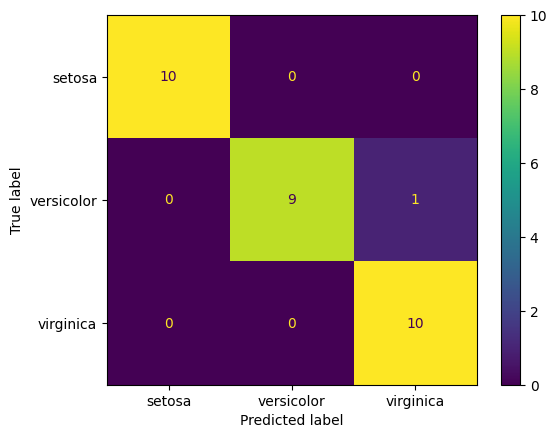

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from dpg import DPGExplainer

IMG_DIR = Path('images')
IMG_DIR.mkdir(parents=True, exist_ok=True)

iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=10, random_state=27)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=iris.target_names)
disp.plot()
disp.figure_.savefig(IMG_DIR / 'rf_confusion_matrix.png', dpi=200, bbox_inches='tight')
print(classification_report(y_test, y_pred, target_names=iris.target_names))


### 3.1 Pair Plot (All Features by Class)


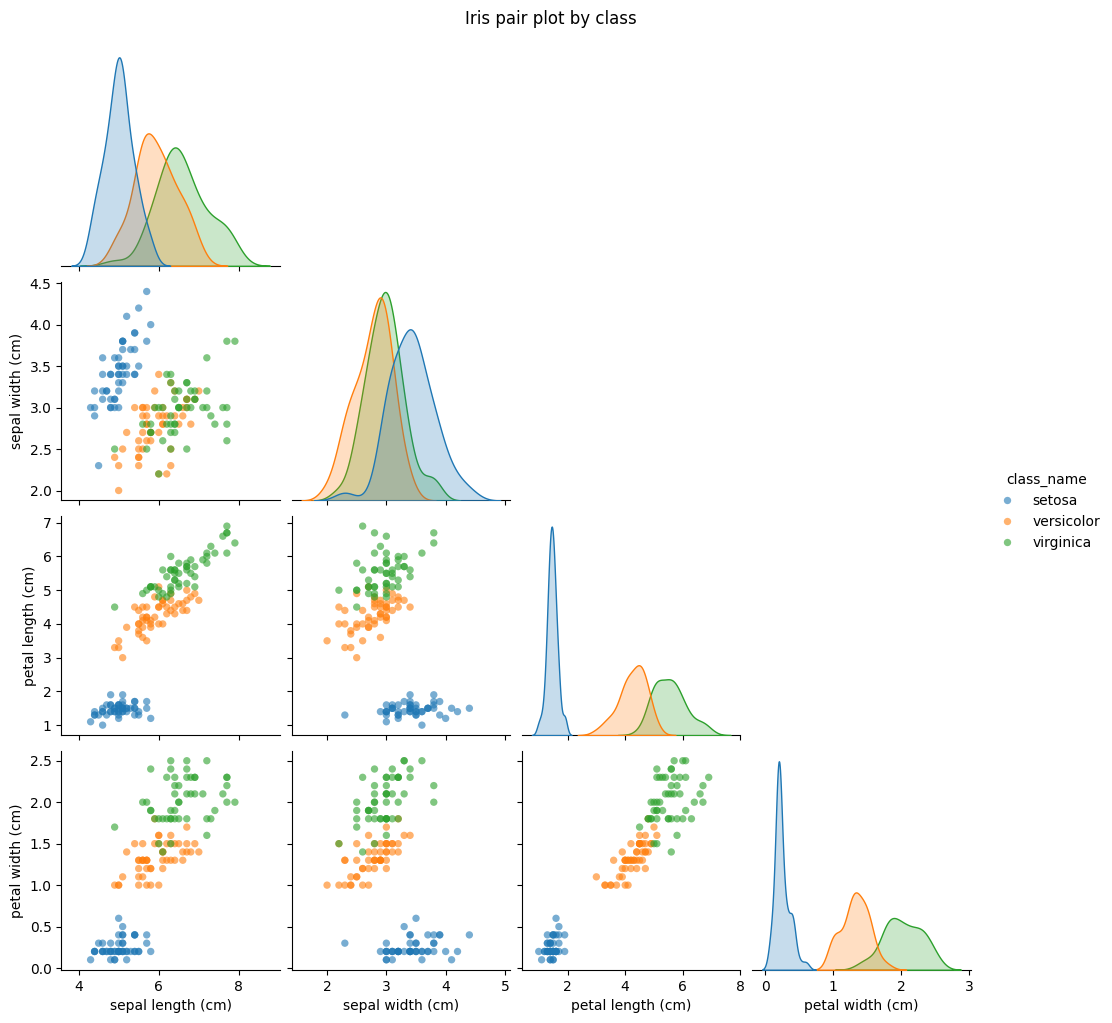

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

pair_df = X.copy()
pair_df['class_name'] = y.map(lambda i: iris.target_names[i])

g = sns.pairplot(
    pair_df,
    hue='class_name',
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.6, 's': 28, 'edgecolor': 'none'},
)
g.fig.suptitle('Iris pair plot by class', y=1.02)
g.fig.savefig(IMG_DIR / 'pairplot.png', dpi=200, bbox_inches='tight')
plt.show()


## 4. Extracting DPG from RF

Next, we extract the DPG from our RF model. The parameters `feature_names` and `target_names` provide readable output for the mapped scenarios.


In [5]:
explainer = DPGExplainer(
    model=model,
    feature_names=X.columns,
    target_names=iris.target_names.tolist(),
    config_file="config.yaml",  # optional if present
)

explanation = explainer.explain_global(
    X.values,
    communities=True,
    community_threshold=0.2,
)


Config file not found at 'config.yaml'. Using built-in defaults.
DPG initialized with perc_var=1e-09, decimal_threshold=6, n_jobs=-1

Starting DPG extraction *****************************************
Model Class: RandomForestClassifier
Model Class Module: sklearn.ensemble._forest
Model Estimators:  10
Model Params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
*****************************************************************


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:01<00:00, 84.01it/s]


Total of paths: 1500
Building DPG...


Processing cases: 100%|██████████| 1500/1500 [00:00<00:00, 34115.75it/s]


Extracting graph...


/Users/barbon/Python/DPG/.venv/lib/python3.11/site-packages/metrics/graph.py:246: RuntimeWarning: divide by zero encountered in matmul
  B = N @ R
/Users/barbon/Python/DPG/.venv/lib/python3.11/site-packages/metrics/graph.py:246: RuntimeWarning: overflow encountered in matmul
  B = N @ R
/Users/barbon/Python/DPG/.venv/lib/python3.11/site-packages/metrics/graph.py:246: RuntimeWarning: invalid value encountered in matmul
  B = N @ R


## 5. Read the DPG Metrics


In [6]:
explanation.node_metrics.head()


,Node,Degree,In degree nodes,Out degree nodes,Betweenness centrality,Local reaching centrality,Label
0,1155626338342785993756224741462529235742838921570,12,4,8,0.066874,1.370273,petal length (cm) <= 4.95
1,1430211056767430292707122197817988587774453780846,2,1,1,0.001035,0.000608,sepal length (cm) > 6.6
2,1130721551439099696578385742755576245540083153693,24,24,0,0.000000,0.000000,Class versicolor
3,890969315352235674076684635636133551807048881777,3,1,2,0.009110,0.003647,sepal length (cm) <= 6.1
4,583382121977559965674996862505623792063344319002,2,1,1,0.000207,0.000608,sepal width (cm) <= 2.1


**Local Reaching Centrality (LRC)**
- High LRC nodes can reach many other nodes downstream.
- These predicates often act early, framing large portions of the model’s logic.

**Betweenness Centrality (BC)**
- High BC nodes lie on many shortest paths between other nodes.
- These predicates are “bottlenecks” that connect major decision flows.


## 6. Compare Top LRC Predicates vs Random Forest Importance


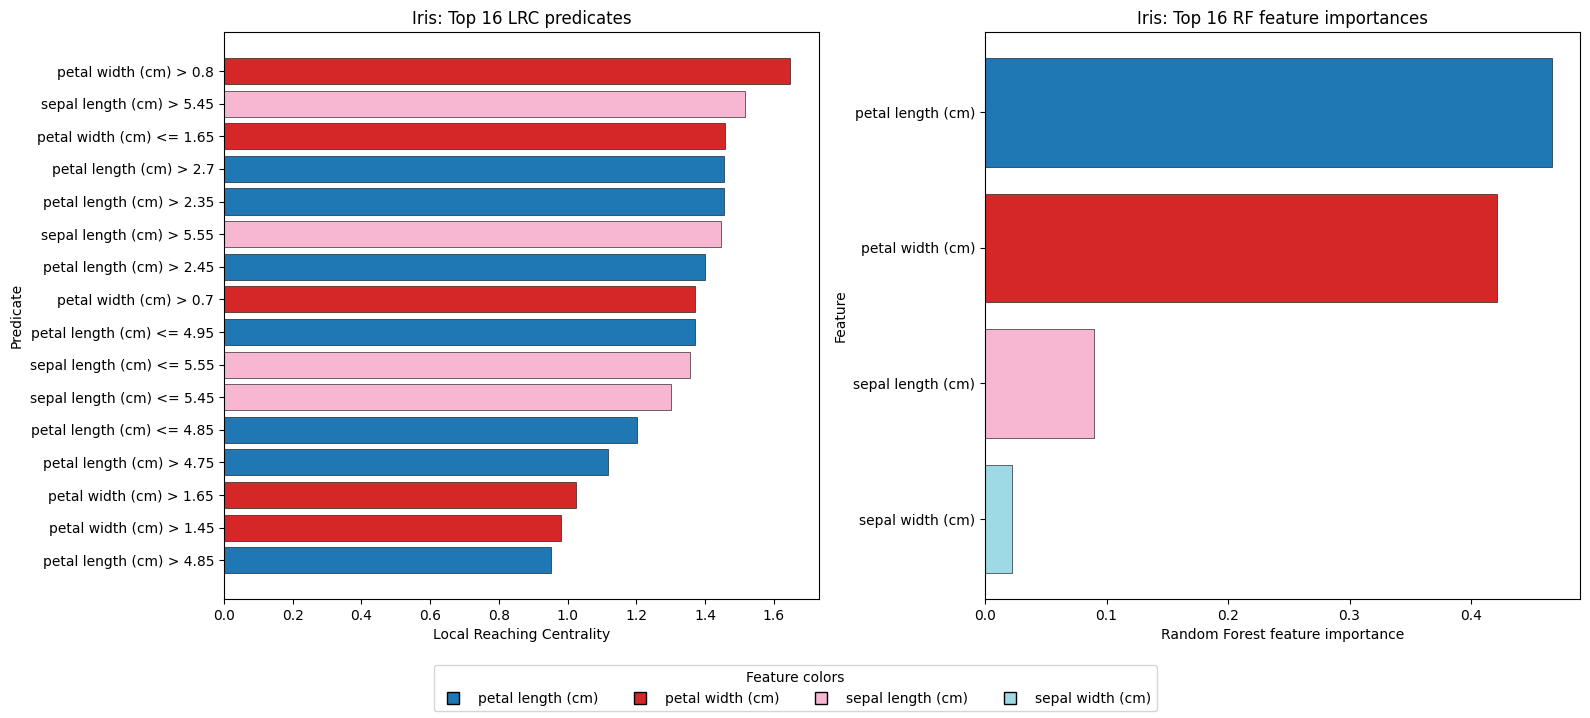

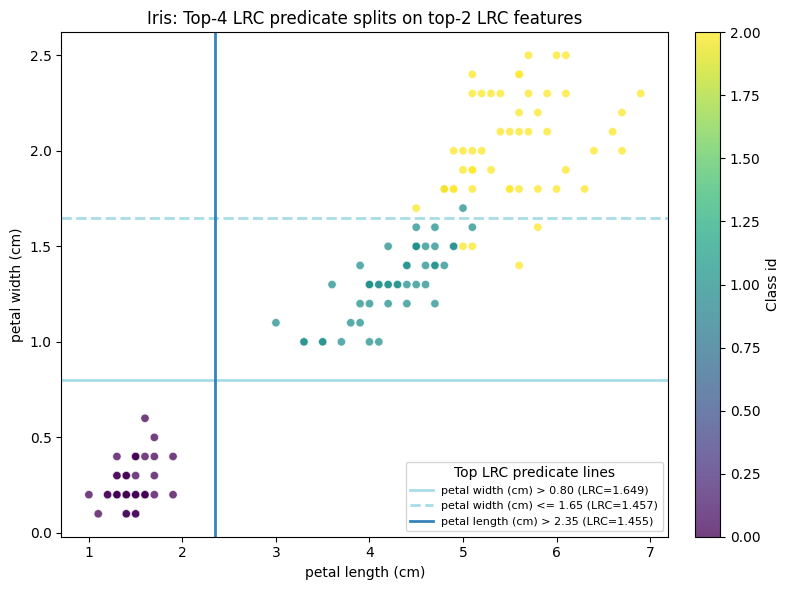

In [7]:
import re

def parse_predicate_parts(label: str):
    m = re.search(r"(.+?)\s*(<=|>)\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", str(label))
    if not m:
        return None
    feature = m.group(1).strip()
    op = m.group(2)
    threshold = float(m.group(3))
    return feature, op, threshold


def parse_feature_from_predicate(label: str) -> str:
    parts = parse_predicate_parts(label)
    return parts[0] if parts else str(label)


def lrc_predicate_scores(explanation, top_k=10):
    nm = explanation.node_metrics.copy()
    nm = nm[nm["Label"].str.contains("<=", regex=False, na=False) | nm["Label"].str.contains(">", regex=False, na=False)].copy()
    nm = nm.sort_values("Local reaching centrality", ascending=False).head(top_k)

    rows = []
    for _, r in nm.iterrows():
        parsed = parse_predicate_parts(r["Label"])
        if not parsed:
            continue
        feature, op, threshold = parsed
        rows.append({
            "predicate": str(r["Label"]),
            "feature": feature,
            "op": op,
            "threshold": threshold,
            "lrc": float(r["Local reaching centrality"]),
        })

    return pd.DataFrame(rows)


def _feature_color_map(features):
    unique = list(dict.fromkeys(features))
    cmap = plt.cm.tab20
    if len(unique) <= 1:
        return {unique[0]: cmap(0)} if unique else {}
    return {f: cmap(i / (len(unique) - 1)) for i, f in enumerate(unique)}


def plot_lrc_vs_rf_importance(explanation, model, X_df, top_k=10, dataset_name='Iris', save_path=None):
    top_lrc = lrc_predicate_scores(explanation, top_k=top_k).copy()

    top_rf = (
        pd.DataFrame({
            "feature": list(getattr(model, "feature_names_in_", X_df.columns)),
            "rf_importance": model.feature_importances_.astype(float),
        })
        .sort_values("rf_importance", ascending=False)
        .head(top_k)
    )

    # Sort ascending for readable horizontal bars
    top_lrc_plot = top_lrc.sort_values("lrc", ascending=True)
    top_rf_plot = top_rf.sort_values("rf_importance", ascending=True)

    # Keep feature colors consistent across both plots
    all_features = top_lrc_plot["feature"].tolist() + top_rf_plot["feature"].tolist()
    feature_to_color = _feature_color_map(all_features)

    fig, axes = plt.subplots(1, 2, figsize=(16, max(5, top_k * 0.45)))

    axes[0].barh(
        top_lrc_plot["predicate"],
        top_lrc_plot["lrc"],
        color=[feature_to_color[f] for f in top_lrc_plot["feature"]],
        edgecolor="black",
        linewidth=0.4,
    )
    axes[0].set_title(f"{dataset_name}: Top {top_k} LRC predicates")
    axes[0].set_xlabel("Local Reaching Centrality")
    axes[0].set_ylabel("Predicate")

    axes[1].barh(
        top_rf_plot["feature"],
        top_rf_plot["rf_importance"],
        color=[feature_to_color[f] for f in top_rf_plot["feature"]],
        edgecolor="black",
        linewidth=0.4,
    )
    axes[1].set_title(f"{dataset_name}: Top {top_k} RF feature importances")
    axes[1].set_xlabel("Random Forest feature importance")
    axes[1].set_ylabel("Feature")

    legend_features = list(dict.fromkeys(all_features))
    legend_handles = [
        plt.Line2D([0], [0], marker='s', color='w', label=f,
                   markerfacecolor=feature_to_color[f], markeredgecolor='black', markersize=8)
        for f in legend_features
    ]
    fig.legend(handles=legend_handles, title="Feature colors",
               loc="lower center", ncol=min(4, max(1, len(legend_handles))), frameon=True)

    plt.tight_layout(rect=(0, 0.08, 1, 1))
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()


def plot_top_lrc_predicate_splits(explanation, X_df, y, top_predicates=5, top_features=2, dataset_name='Iris', save_path=None):
    top_lrc = lrc_predicate_scores(explanation, top_k=max(top_predicates, 10)).copy()
    top5 = top_lrc.sort_values("lrc", ascending=False).head(top_predicates).copy()

    # Select top-2 LRC features using cumulative LRC contribution
    feature_rank = (
        top_lrc.groupby("feature", as_index=False)["lrc"].sum()
        .sort_values("lrc", ascending=False)
        .head(top_features)
    )
    selected_features = feature_rank["feature"].tolist()
    if len(selected_features) < 2:
        print(f"{dataset_name}: not enough LRC features to build a 2D split plot.")
        return

    fx, fy = selected_features[0], selected_features[1]
    if fx not in X_df.columns or fy not in X_df.columns:
        print(f"{dataset_name}: selected LRC features not present in input dataframe columns.")
        return

    # Lines from top-5 predicates only, restricted to top-2 selected features
    split_rows = top5[top5["feature"].isin([fx, fy])].copy()

    fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.scatter(
        X_df[fx],
        X_df[fy],
        c=y,
        cmap='viridis',
        s=36,
        alpha=0.75,
        edgecolor='white',
        linewidth=0.5,
    )

    # Color by feature to keep consistency with section colors
    feature_to_color = _feature_color_map([fx, fy])

    line_labels_seen = set()
    for _, r in split_rows.iterrows():
        f, op, thr, score = r["feature"], r["op"], r["threshold"], r["lrc"]
        if f == fx:
            ls = '--' if op == '<=' else '-'
            label = f"{f} {op} {thr:.2f} (LRC={score:.3f})"
            ax.axvline(
                thr,
                color=feature_to_color[f],
                linestyle=ls,
                linewidth=2,
                alpha=0.9,
                label=label if label not in line_labels_seen else None,
            )
            line_labels_seen.add(label)
        elif f == fy:
            ls = '--' if op == '<=' else '-'
            label = f"{f} {op} {thr:.2f} (LRC={score:.3f})"
            ax.axhline(
                thr,
                color=feature_to_color[f],
                linestyle=ls,
                linewidth=2,
                alpha=0.9,
                label=label if label not in line_labels_seen else None,
            )
            line_labels_seen.add(label)

    ax.set_title(
        f"{dataset_name}: Top-{top_predicates} LRC predicate splits on top-2 LRC features"
    )
    ax.set_xlabel(fx)
    ax.set_ylabel(fy)

    # class legend + predicate legend
    cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Class id')

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, title='Top LRC predicate lines', loc='best', fontsize=8)

    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()


plot_lrc_vs_rf_importance(
    explanation, model, X, top_k=16, dataset_name='Iris',
    save_path=IMG_DIR / 'lrc_vs_rf_importance.png'
)
plot_top_lrc_predicate_splits(
    explanation, X, y, top_predicates=4, top_features=2, dataset_name='Iris',
    save_path=IMG_DIR / 'top_lrc_predicate_splits.png'
)



### Optional: inspect top-10 LRC and RF tables


In [8]:
top_lrc = lrc_predicate_scores(explanation, top_k=10)
top_rf = (
    pd.DataFrame({
        "feature": list(getattr(model, "feature_names_in_", X.columns)),
        "rf_importance": model.feature_importances_.astype(float),
    })
    .sort_values("rf_importance", ascending=False)
    .head(10)
)

top_lrc
top_rf



,feature,rf_importance
2,petal length (cm),0.466382
3,petal width (cm),0.421746
0,sepal length (cm),0.089834
1,sepal width (cm),0.022037


Interpretation guide:
- If a predicate has **high LRC**, it likely sets an early rule that shapes many later decisions.
- If a feature has **high RF importance**, it contributes strongly to split quality across the forest.
- Compare overlap: when high-LRC predicates and high-RF features agree, the global graph and model-level importance tell a consistent story.

### BC analysis
This notebook includes a BC bottleneck cloud in PCA space (Section 7).
A full BC ranking-focused analysis will be covered in a separate session/notebook.


## 7. Show BC Bottleneck Cloud in PCA Space


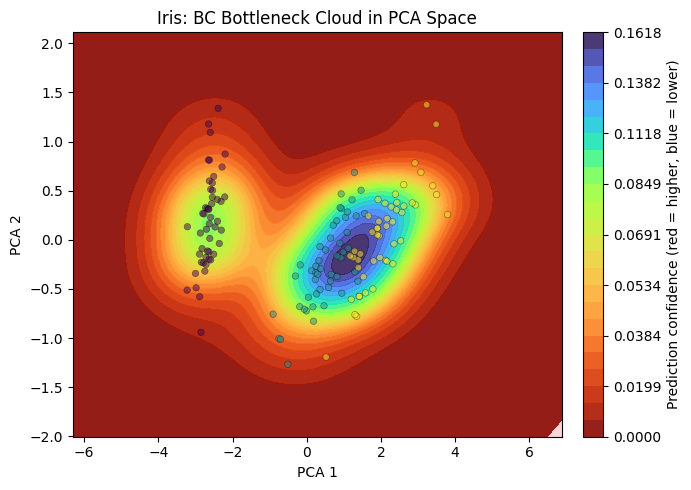

In [9]:
import seaborn as sns
from sklearn.decomposition import PCA

def bc_weights_from_explanation(explanation, X_df, top_k=10):
    nm = explanation.node_metrics.copy()
    nm = nm[nm["Label"].str.contains("<=", regex=False, na=False) | nm["Label"].str.contains(">", regex=False, na=False)].copy()
    top_bc = nm.sort_values("Betweenness centrality", ascending=False).head(top_k)

    weights = np.zeros(len(X_df), dtype=float)

    for _, row in top_bc.iterrows():
        parsed = re.search(r"(.+?)\s*(<=|>)\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", str(row["Label"]))
        if not parsed:
            continue
        feature = parsed.group(1).strip()
        op = parsed.group(2)
        threshold = float(parsed.group(3))
        if feature not in X_df.columns:
            continue

        vals = X_df[feature].values
        vals = np.where(np.isfinite(vals), vals, np.nan)
        if op == '<=':
            weights += (vals <= threshold)
        else:
            weights += (vals > threshold)

    if weights.max() > 0:
        weights = weights / weights.max()
    return weights


def pca_kde_plot(X_df, y, weights, title, save_path=None):
    X_clean = X_df.replace([np.inf, -np.inf], np.nan)
    valid_mask = ~X_clean.isna().any(axis=1)
    X_valid = X_clean[valid_mask]
    y_valid = y[valid_mask]
    w_valid = weights[valid_mask]

    pca = PCA(n_components=2, random_state=27)
    X_pca = pca.fit_transform(X_valid)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor='white')
    ax.set_facecolor('#f6d6d6')

    try:
        kde = sns.kdeplot(
            x=X_pca[:, 0],
            y=X_pca[:, 1],
            weights=w_valid,
            fill=True,
            levels=25,
            cmap='turbo_r',
            alpha=0.9,
            thresh=0.0,
            bw_adjust=1.15,
            ax=ax,
        )
        if hasattr(kde, 'collections') and kde.collections:
            cbar = fig.colorbar(kde.collections[0], ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Prediction confidence (red = higher, blue = lower)')
    except Exception:
        hb = ax.hexbin(
            X_pca[:, 0],
            X_pca[:, 1],
            C=w_valid,
            reduce_C_function=np.mean,
            gridsize=35,
            cmap='turbo_r',
            mincnt=1,
            alpha=0.9,
        )
        cbar = fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Prediction confidence (red = higher, blue = lower)')

    ax.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=y_valid,
        cmap='viridis',
        s=22,
        alpha=0.5,
        edgecolor='k',
        linewidth=0.4,
    )

    ax.set_title(title)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()


weights = bc_weights_from_explanation(explanation, X, top_k=10)
pca_kde_plot(
    X, y, weights, 'Iris: BC Bottleneck Cloud in PCA Space',
    save_path=IMG_DIR / 'bc_bottleneck_pca_cloud.png'
)



## 8. Communities (Decision Themes + Class Complexity)

Beyond visualization, we quantify class complexity with class-vs-feature predicate counts:
- Heatmap (absolute counts): how many predicates involving each feature can reach each class node
- Heatmap (row-normalized): per-class feature distribution
- Bar plots: predicate volume and unique feature coverage per class


In [10]:
# Communities overview + complexity-oriented class-feature analysis
import seaborn as sns
import networkx as nx

def parse_predicate_parts(label):
    m = re.search(r"(.+?)\s*(<=|>)\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", str(label))
    if not m:
        return None
    return m.group(1).strip(), m.group(2), float(m.group(3))


def _resolve_graph_node(G, candidate):
    if candidate in G:
        return candidate
    c = str(candidate)
    for n in G.nodes:
        if str(n) == c:
            return n
    return None


def class_feature_predicate_counts(explanation):
    nm = explanation.node_metrics.copy()
    if 'Node' not in nm.columns or 'Label' not in nm.columns:
        raise ValueError('node_metrics must contain Node and Label columns')

    G = getattr(explanation, 'graph', None)
    if G is None:
        raise ValueError('explanation.graph is required for class-path analysis')

    class_df = nm[nm['Label'].astype(str).str.startswith('Class ')].copy()
    class_nodes = {}
    for _, row in class_df.iterrows():
        class_node = _resolve_graph_node(G, row['Node'])
        if class_node is not None:
            class_nodes[class_node] = str(row['Label']).replace('Class ', '', 1)

    pred = nm.copy()
    pred['parsed'] = pred['Label'].apply(parse_predicate_parts)
    pred = pred[pred['parsed'].notna()].copy()

    pred_node_lookup = {}
    for _, r in pred.iterrows():
        n = _resolve_graph_node(G, r['Node'])
        if n is None:
            continue
        feature, op, threshold = r['parsed']
        pred_node_lookup[n] = (str(feature), str(op), float(threshold))

    _comm_fn = globals().get('_community_specs')
    if callable(_comm_fn):
        comm_specs = _comm_fn(explanation, G, nm)
    else:
        # Fallback if helper cell was not executed yet.
        comm = getattr(explanation, 'communities', None) or {}
        raw = []
        if isinstance(comm, dict) and 'Clusters' in comm:
            for key, members in comm.get('Clusters', {}).items():
                cls = str(key).replace('Class ', '', 1)
                if cls.lower() == 'ambiguous':
                    cls = None
                raw.append({'class_name': cls, 'members': members})
        elif isinstance(comm, dict) and 'Communities' in comm:
            for members in comm.get('Communities', []):
                raw.append({'class_name': None, 'members': members})

        label_to_nodes = {}
        for _, rr in nm.iterrows():
            label_to_nodes.setdefault(str(rr['Label']), []).append(rr['Node'])

        comm_specs = []
        for idx, spec in enumerate(raw):
            resolved = set()
            for item in spec['members']:
                n = _resolve_graph_node(G, item)
                if n is not None:
                    resolved.add(n)
                    continue
                for cand in label_to_nodes.get(str(item), []):
                    n2 = _resolve_graph_node(G, cand)
                    if n2 is not None:
                        resolved.add(n2)
            if resolved:
                comm_specs.append({'community_id': idx, 'class_name': spec['class_name'], 'nodes': resolved})
    if not comm_specs:
        comm_specs = [{
            'community_id': 0,
            'class_name': None,
            'nodes': set(pred_node_lookup.keys()),
        }]

    class_feature_counts = {}
    for spec in comm_specs:
        cls_from_cluster = spec['class_name']
        for n in spec['nodes']:
            if n not in pred_node_lookup:
                continue
            feature, _, _ = pred_node_lookup[n]

            if cls_from_cluster is not None:
                target_classes = [str(cls_from_cluster)]
            else:
                desc = nx.descendants(G, n)
                target_classes = [class_nodes[c] for c in class_nodes if c in desc]

            for cls in target_classes:
                class_feature_counts.setdefault(cls, []).append(feature)

    if not class_feature_counts:
        return pd.DataFrame()

    count_series = {k: pd.Series(v).value_counts() for k, v in class_feature_counts.items() if len(v) > 0}
    if not count_series:
        return pd.DataFrame()

    heat = pd.DataFrame(count_series).T.fillna(0).astype(int)
    heat = heat.loc[:, heat.sum(axis=0).sort_values(ascending=False).index]
    return heat


def plot_class_feature_complexity(heat_df, dataset_name='Iris', top_n_features=15, save_prefix=None):
    if heat_df.empty:
        print(f'{dataset_name}: no class-feature predicate counts available.')
        return

    h = heat_df.copy()
    if h.shape[1] > top_n_features:
        h = h.iloc[:, :top_n_features]

    h_norm = h.div(h.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    fig, axes = plt.subplots(1, 2, figsize=(18, max(5, 0.6 * len(h.index) + 2)))

    sns.heatmap(
        h,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        linewidths=0.4,
        linecolor='white',
        ax=axes[0],
    )
    axes[0].set_title(f'{dataset_name}: Class vs Feature predicate counts')
    axes[0].set_xlabel('Feature')
    axes[0].set_ylabel('Class')

    sns.heatmap(
        h_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        linewidths=0.4,
        linecolor='white',
        ax=axes[1],
    )
    axes[1].set_title(f'{dataset_name}: Row-normalized feature share by class')
    axes[1].set_xlabel('Feature')
    axes[1].set_ylabel('Class')

    plt.tight_layout()
    if save_prefix is not None:
        fig.savefig(save_prefix + '_heatmap.png', dpi=200, bbox_inches='tight')
    plt.show()

    complexity = pd.DataFrame({
        'total_predicates': h.sum(axis=1),
        'unique_features': (h > 0).sum(axis=1),
    }).sort_values('total_predicates', ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.barplot(
        x=complexity.index,
        y=complexity['total_predicates'],
        palette='Reds_r',
        ax=axes[0],
    )
    axes[0].set_title(f'{dataset_name}: Predicate volume by class')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Total predicate count')

    sns.barplot(
        x=complexity.index,
        y=complexity['unique_features'],
        palette='Blues_r',
        ax=axes[1],
    )
    axes[1].set_title(f'{dataset_name}: Feature coverage by class')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Unique features in predicates')

    plt.tight_layout()
    if save_prefix is not None:
        fig.savefig(save_prefix + '_bars.png', dpi=200, bbox_inches='tight')
    plt.show()




In [11]:
explanation.communities.keys()
explanation.communities.get("Clusters", explanation.communities.get("Communities", []))


{'Class setosa': ['sepal width (cm) > 3.8',
  'Class setosa',
  'sepal width (cm) > 3.9',
  'sepal length (cm) <= 5.45',
  'sepal length (cm) <= 5.55',
  'petal width (cm) <= 0.8',
  'petal length (cm) <= 2.7',
  'petal width (cm) <= 0.7',
  'petal length (cm) <= 2.35',
  'petal length (cm) <= 2.45'],
 'Class versicolor': ['petal length (cm) <= 4.95',
  'sepal length (cm) > 6.6',
  'Class versicolor',
  'sepal width (cm) <= 2.1',
  'sepal width (cm) <= 2.25',
  'sepal length (cm) > 6.1',
  'sepal width (cm) > 3.0',
  'petal length (cm) <= 4.85',
  'petal width (cm) <= 1.6',
  'petal width (cm) <= 1.75',
  'petal length (cm) <= 4.75',
  'sepal length (cm) <= 6.05',
  'petal length (cm) > 4.65',
  'petal width (cm) <= 1.65',
  'sepal length (cm) <= 6.35',
  'sepal width (cm) > 3.2',
  'sepal width (cm) <= 2.65',
  'petal width (cm) <= 1.45',
  'sepal width (cm) <= 2.75',
  'petal width (cm) > 0.8',
  'sepal length (cm) <= 6.15',
  'petal width (cm) <= 1.55',
  'petal width (cm) <= 1.7',


Plotting DPG...


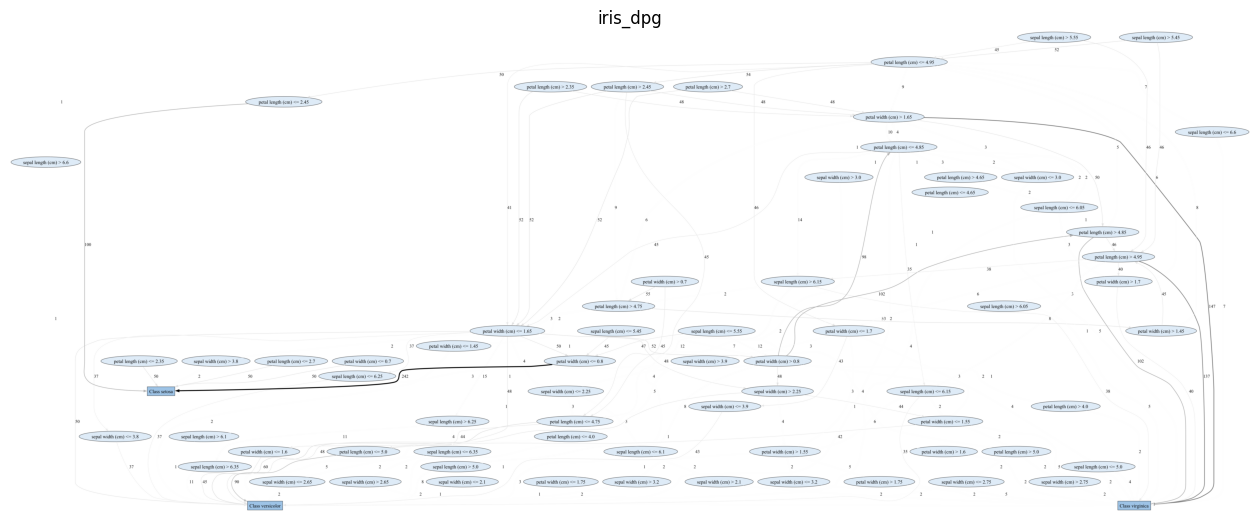

In [12]:
run_name = "iris_dpg"
explainer.plot(run_name, explanation, save_dir=str(IMG_DIR), class_flag=True, export_pdf=True)


Plotting DPG (communities)...


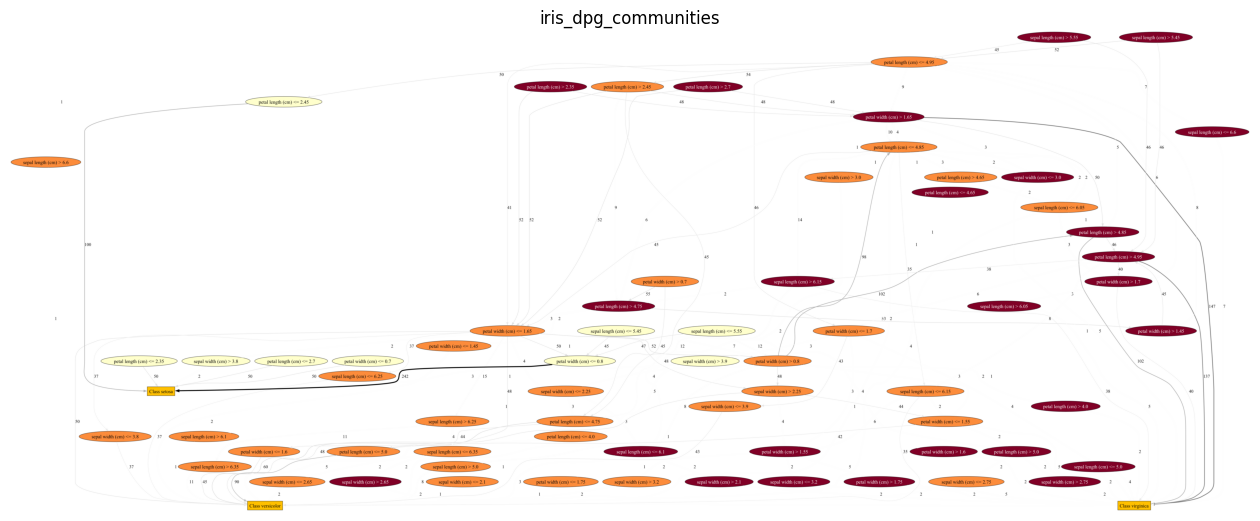

In [13]:
run_name = "iris_dpg"
explainer.plot_communities(run_name, explanation, save_dir=str(IMG_DIR), class_flag=True, export_pdf=True)


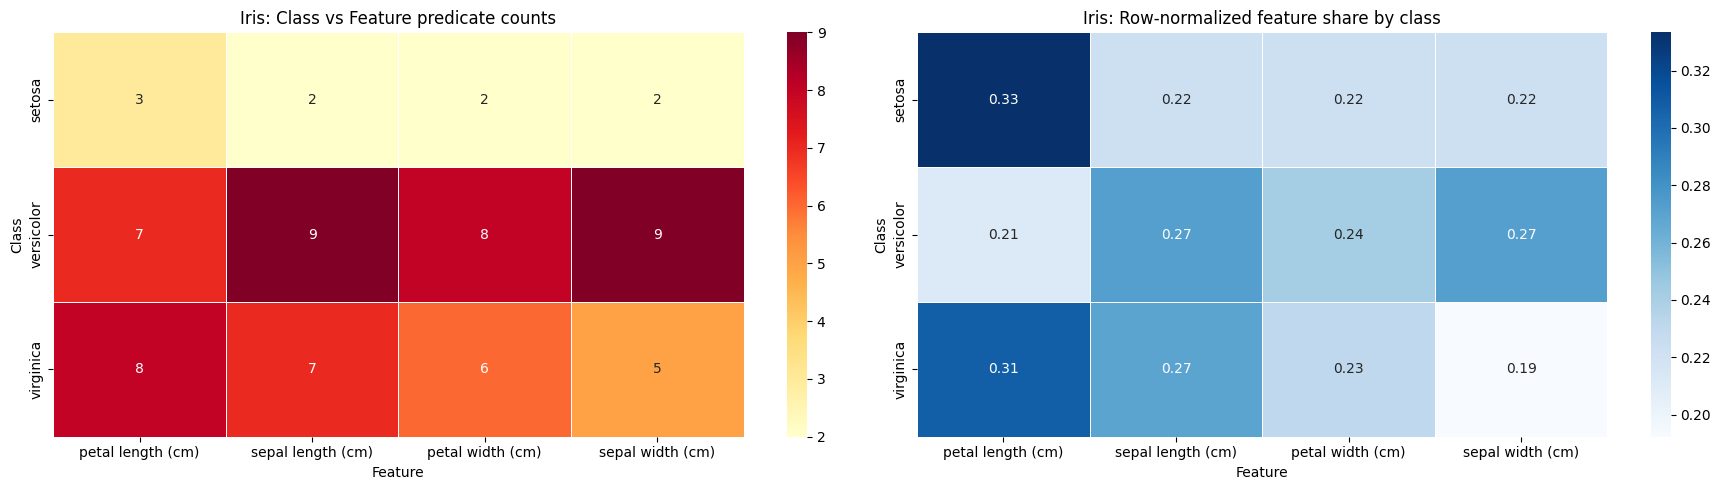

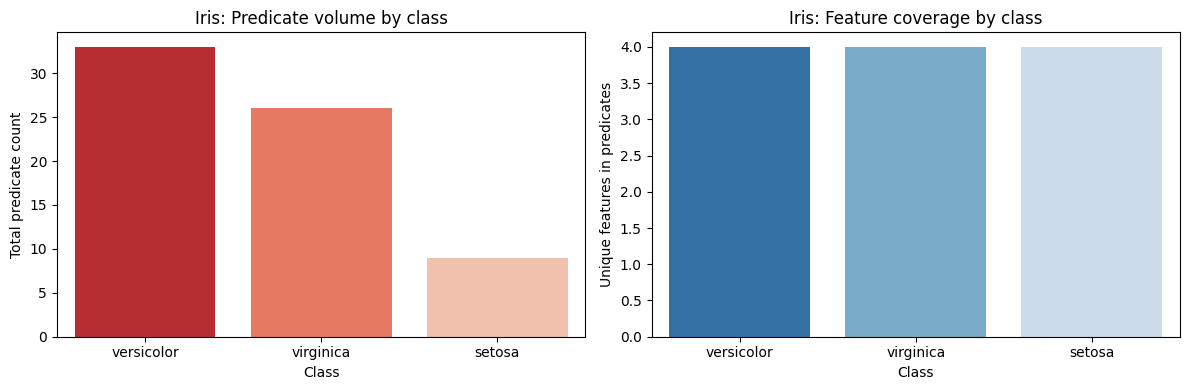

In [14]:
heat = class_feature_predicate_counts(explanation)
plot_class_feature_complexity(
    heat, dataset_name='Iris', top_n_features=15,
    save_prefix=str(IMG_DIR / 'communities_class_feature_complexity')
)


In [15]:


def _normalize_class_label(label):
    s = str(label)
    if s.startswith('Class '):
        return s.replace('Class ', '', 1)
    return s


def _community_specs(explanation, G, node_df):
    comm = getattr(explanation, 'communities', None)
    if not comm:
        return []

    # Build a normalized list of community specs so we keep DPGExplainer
    # cluster->class correlation when 'Clusters' is available.
    raw_specs = []
    if isinstance(comm, dict) and 'Clusters' in comm:
        for key, members in comm.get('Clusters', {}).items():
            cls = _normalize_class_label(key)
            # Ambiguous has no direct dataset class counterpart.
            if str(cls).lower() == 'ambiguous':
                cls = None
            raw_specs.append({'class_name': cls, 'members': members})
    elif isinstance(comm, dict) and 'Communities' in comm:
        for members in comm.get('Communities', []):
            raw_specs.append({'class_name': None, 'members': members})

    # Label-to-node fallback in case community entries are labels instead of node ids
    label_to_nodes = {}
    for _, r in node_df.iterrows():
        label_to_nodes.setdefault(str(r['Label']), []).append(r['Node'])

    out = []
    for idx, spec in enumerate(raw_specs):
        resolved = set()
        for item in spec['members']:
            n = _resolve_graph_node(G, item)
            if n is not None:
                resolved.add(n)
                continue

            # fallback: interpret as label
            for cand in label_to_nodes.get(str(item), []):
                n2 = _resolve_graph_node(G, cand)
                if n2 is not None:
                    resolved.add(n2)

        if resolved:
            out.append({
                'community_id': idx,
                'class_name': spec['class_name'],
                'nodes': resolved,
            })

    return out


def classwise_feature_bounds_from_communities(explanation):
    nm = explanation.node_metrics.copy()
    G = getattr(explanation, 'graph', None)
    if G is None:
        raise ValueError('explanation.graph is required')

    class_df = nm[nm['Label'].astype(str).str.startswith('Class ')].copy()
    class_nodes = {}
    for _, r in class_df.iterrows():
        n = _resolve_graph_node(G, r['Node'])
        if n is not None:
            class_nodes[n] = str(r['Label']).replace('Class ', '', 1)

    pred = nm.copy()
    pred['parsed'] = pred['Label'].apply(parse_predicate_parts)
    pred = pred[pred['parsed'].notna()].copy()

    pred_node_lookup = {}
    for _, r in pred.iterrows():
        n = _resolve_graph_node(G, r['Node'])
        if n is None:
            continue
        feature, op, threshold = r['parsed']
        pred_node_lookup[n] = (str(feature), str(op), float(threshold))

    _comm_fn = globals().get('_community_specs')
    if callable(_comm_fn):
        comm_specs = _comm_fn(explanation, G, nm)
    else:
        # Fallback if helper cell was not executed yet.
        comm = getattr(explanation, 'communities', None) or {}
        raw = []
        if isinstance(comm, dict) and 'Clusters' in comm:
            for key, members in comm.get('Clusters', {}).items():
                cls = str(key).replace('Class ', '', 1)
                if cls.lower() == 'ambiguous':
                    cls = None
                raw.append({'class_name': cls, 'members': members})
        elif isinstance(comm, dict) and 'Communities' in comm:
            for members in comm.get('Communities', []):
                raw.append({'class_name': None, 'members': members})

        label_to_nodes = {}
        for _, rr in nm.iterrows():
            label_to_nodes.setdefault(str(rr['Label']), []).append(rr['Node'])

        comm_specs = []
        for idx, spec in enumerate(raw):
            resolved = set()
            for item in spec['members']:
                n = _resolve_graph_node(G, item)
                if n is not None:
                    resolved.add(n)
                    continue
                for cand in label_to_nodes.get(str(item), []):
                    n2 = _resolve_graph_node(G, cand)
                    if n2 is not None:
                        resolved.add(n2)
            if resolved:
                comm_specs.append({'community_id': idx, 'class_name': spec['class_name'], 'nodes': resolved})
    if not comm_specs:
        print('No resolved communities found; falling back to all predicate nodes.')
        comm_specs = [{
            'community_id': 0,
            'class_name': None,
            'nodes': set(pred_node_lookup.keys()),
        }]

    # Collect predicate thresholds per (class, community, feature)
    bucket = {}
    for spec in comm_specs:
        ci = int(spec['community_id'])
        cls_from_cluster = spec['class_name']
        nodes = spec['nodes']

        for n in nodes:
            if n not in pred_node_lookup:
                continue
            feature, op, threshold = pred_node_lookup[n]

            if cls_from_cluster is not None:
                reachable_classes = [str(cls_from_cluster)]
            else:
                desc = nx.descendants(G, n)
                reachable_classes = [class_nodes[c] for c in class_nodes if c in desc]

            if not reachable_classes:
                continue

            for cls in reachable_classes:
                key = (cls, ci, feature)
                bucket.setdefault(key, {'gt': [], 'le': [], 'all': []})
                if op == '>':
                    bucket[key]['gt'].append(threshold)
                elif op == '<=':
                    bucket[key]['le'].append(threshold)
                bucket[key]['all'].append(threshold)

    rows = []
    for (cls, ci, feature), vals in bucket.items():
        # Predicate semantics:
        #   'feature > t'  -> lower bound candidate
        #   'feature <= t' -> upper bound candidate
        # Missing side remains unbounded.
        lower = min(vals['gt']) if vals['gt'] else float('-inf')
        upper = max(vals['le']) if vals['le'] else float('inf')

        # Guard against inconsistent constraints in noisy communities.
        # Keep the widest finite envelope observed inside this bucket.
        if lower > upper:
            lower = min(vals['all']) if vals['all'] else float('-inf')
            upper = max(vals['all']) if vals['all'] else float('inf')

        width = (upper - lower) if (np.isfinite(lower) and np.isfinite(upper)) else np.nan

        rows.append({
            'class_name': cls,
            'community_id': ci,
            'feature': feature,
            'lower_bound': float(lower),
            'upper_bound': float(upper),
            'range_width': float(width) if pd.notna(width) else np.nan,
        })

    if not rows:
        return pd.DataFrame(columns=['class_name', 'community_id', 'feature', 'lower_bound', 'upper_bound', 'range_width'])

    return pd.DataFrame(rows)

def class_feature_predicate_positions(explanation):
    nm = explanation.node_metrics.copy()
    G = getattr(explanation, 'graph', None)
    if G is None:
        raise ValueError('explanation.graph is required')

    class_df = nm[nm['Label'].astype(str).str.startswith('Class ')].copy()
    class_nodes = {}
    for _, r in class_df.iterrows():
        n = _resolve_graph_node(G, r['Node'])
        if n is not None:
            class_nodes[n] = str(r['Label']).replace('Class ', '', 1)

    pred = nm.copy()
    pred['parsed'] = pred['Label'].apply(parse_predicate_parts)
    pred = pred[pred['parsed'].notna()].copy()

    pred_node_lookup = {}
    for _, r in pred.iterrows():
        n = _resolve_graph_node(G, r['Node'])
        if n is None:
            continue
        feature, op, threshold = r['parsed']
        pred_node_lookup[n] = (str(feature), str(op), float(threshold))

    _comm_fn = globals().get('_community_specs')
    if callable(_comm_fn):
        comm_specs = _comm_fn(explanation, G, nm)
    else:
        # Fallback if helper cell was not executed yet.
        comm = getattr(explanation, 'communities', None) or {}
        raw = []
        if isinstance(comm, dict) and 'Clusters' in comm:
            for key, members in comm.get('Clusters', {}).items():
                cls = str(key).replace('Class ', '', 1)
                if cls.lower() == 'ambiguous':
                    cls = None
                raw.append({'class_name': cls, 'members': members})
        elif isinstance(comm, dict) and 'Communities' in comm:
            for members in comm.get('Communities', []):
                raw.append({'class_name': None, 'members': members})

        label_to_nodes = {}
        for _, rr in nm.iterrows():
            label_to_nodes.setdefault(str(rr['Label']), []).append(rr['Node'])

        comm_specs = []
        for idx, spec in enumerate(raw):
            resolved = set()
            for item in spec['members']:
                n = _resolve_graph_node(G, item)
                if n is not None:
                    resolved.add(n)
                    continue
                for cand in label_to_nodes.get(str(item), []):
                    n2 = _resolve_graph_node(G, cand)
                    if n2 is not None:
                        resolved.add(n2)
            if resolved:
                comm_specs.append({'community_id': idx, 'class_name': spec['class_name'], 'nodes': resolved})
    if not comm_specs:
        comm_specs = [{
            'community_id': 0,
            'class_name': None,
            'nodes': set(pred_node_lookup.keys()),
        }]

    rows = []
    for spec in comm_specs:
        ci = int(spec['community_id'])
        cls_from_cluster = spec['class_name']
        nodes = spec['nodes']

        for n in nodes:
            if n not in pred_node_lookup:
                continue

            feature, op, threshold = pred_node_lookup[n]
            if cls_from_cluster is not None:
                target_classes = [str(cls_from_cluster)]
            else:
                desc = nx.descendants(G, n)
                target_classes = [class_nodes[c] for c in class_nodes if c in desc]

            for cls in target_classes:
                rows.append({
                    'class_name': cls,
                    'community_id': ci,
                    'feature': feature,
                    'operator': op,
                    'threshold': threshold,
                })

    if not rows:
        return pd.DataFrame(columns=['class_name', 'community_id', 'feature', 'operator', 'threshold'])

    return pd.DataFrame(rows)


def _aggregate_close_positions(values, tol):
    vals = np.sort(np.asarray(values, dtype=float))
    if vals.size == 0:
        return []

    groups = [[vals[0]]]
    for v in vals[1:]:
        if abs(v - groups[-1][-1]) <= tol:
            groups[-1].append(v)
        else:
            groups.append([v])

    return [(float(np.mean(g)), len(g)) for g in groups]


def _class_lookup_from_target_names(target_names):
    if target_names is None:
        return {}
    return {str(name): i for i, name in enumerate(list(target_names))}


def _class_mask(class_name, y, class_lookup=None):
    # 1) Direct lookup (e.g., {'setosa': 0, ...})
    if class_lookup and str(class_name) in class_lookup:
        return (y == class_lookup[str(class_name)])

    # 2) Numeric class names
    try:
        as_int = int(class_name)
        return (y == as_int)
    except Exception:
        pass

    # 3) String labels in y
    return (pd.Series(y).astype(str).values == str(class_name))


def dataset_feature_bounds_by_class(X_df, y, class_names, class_lookup=None):
    rows = []
    for cls in class_names:
        mask = _class_mask(cls, y, class_lookup=class_lookup)
        Xc = X_df.loc[mask]
        if Xc.empty:
            continue
        for f in X_df.columns:
            rows.append({
                'class_name': str(cls),
                'feature': str(f),
                'ds_lower_bound': float(Xc[f].max()),
                'ds_upper_bound': float(Xc[f].min()),
            })
    return pd.DataFrame(rows)


def plot_dpg_class_bounds_vs_dataset_feature_ranges(class_bounds, X_df, y, dataset_name='Iris', top_features=4, class_lookup=None, predicate_positions=None, class_filter=None, density_tol_ratio=0.03, predicate_alpha=0.55, dataset_range_lw=10, save_path=None):
    if class_bounds.empty:
        print(f'{dataset_name}: class bounds are empty.')
        return

    # Same aggregated class-level DPG bounds used in the class range summary plot
    dpg_bounds = (
        class_bounds.groupby(['class_name', 'feature'], as_index=False)
        .agg(
            lower_bound=('lower_bound', 'min'),
            upper_bound=('upper_bound', 'max'),
            community_support=('community_id', 'nunique'),
        )
    )

    dpg_bounds['range_width'] = np.where(
        np.isfinite(dpg_bounds['lower_bound']) & np.isfinite(dpg_bounds['upper_bound']),
        dpg_bounds['upper_bound'] - dpg_bounds['lower_bound'],
        np.nan,
    )

    classes = sorted(dpg_bounds['class_name'].unique())

    # Optional filtering: plot only selected class(es).
    if class_filter is not None:
        if isinstance(class_filter, (list, tuple, set, np.ndarray, pd.Series)):
            allowed = {str(v) for v in class_filter}
        else:
            allowed = {str(class_filter)}
        classes = [c for c in classes if str(c) in allowed]
        if not classes:
            print(f"{dataset_name}: no classes matched class_filter={class_filter!r}.")
            return

    ds_bounds = dataset_feature_bounds_by_class(X_df, y, classes, class_lookup=class_lookup)

    n = len(classes)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    axes = axes[0]

    density_gt_labeled = False
    density_le_labeled = False

    for ax, cls in zip(axes, classes):
        cdf = dpg_bounds[dpg_bounds['class_name'] == cls].copy()
        cdf = cdf.sort_values(['community_support', 'range_width'], ascending=[False, False]).head(top_features)
        cdf = cdf.sort_values('range_width', ascending=True)

        merged = cdf.merge(
            ds_bounds[ds_bounds['class_name'] == cls],
            on=['class_name', 'feature'],
            how='left',
        )

        y_pos = np.arange(len(merged))

        # Axis limits from the most extreme values available in this scope.
        # Start from class-level dataset bounds for selected features.
        ds_min = float(merged['ds_lower_bound'].min())
        ds_max = float(merged['ds_upper_bound'].max())

        # Include original dataset extrema for these plotted features.
        feature_global_min = float(X_df[merged['feature']].min().min())
        feature_global_max = float(X_df[merged['feature']].max().max())

        # Include finite DPG bounds if they are more extreme.
        dpg_lo_axis = merged['lower_bound'].astype(float).to_numpy(copy=True)
        dpg_hi_axis = merged['upper_bound'].astype(float).to_numpy(copy=True)
        finite_dpg_lo = dpg_lo_axis[np.isfinite(dpg_lo_axis)]
        finite_dpg_hi = dpg_hi_axis[np.isfinite(dpg_hi_axis)]
        dpg_min = float(finite_dpg_lo.min()) if finite_dpg_lo.size else ds_min
        dpg_max = float(finite_dpg_hi.max()) if finite_dpg_hi.size else ds_max

        x_min = min(ds_min, feature_global_min, dpg_min)
        x_max = max(ds_max, feature_global_max, dpg_max)

        # Requested behavior: do not allow negative lower bound.
        x_min = max(0.0, x_min)

        pad = max((x_max - x_min) * 0.2, 1e-6)
        left_lim, right_lim = x_min - pad, x_max + pad
        left_lim = max(0.0, left_lim)

        # Dataset ranges (reference) in gray
        ax.hlines(y_pos, merged['ds_lower_bound'], merged['ds_upper_bound'],
                  color='lightgray', linewidth=dataset_range_lw, alpha=0.85, label='dataset class range' if cls == classes[0] else None)
        ax.scatter(merged['ds_lower_bound'], y_pos, color='dimgray', s=28,
                   label='dataset min/max' if cls == classes[0] else None)
        ax.scatter(merged['ds_upper_bound'], y_pos, color='dimgray', s=28)

        # DPG community-derived ranges in blue (including unbounded sides).
        dpg_lo = merged['lower_bound'].astype(float).to_numpy(copy=True)
        dpg_hi = merged['upper_bound'].astype(float).to_numpy(copy=True)
        lo_inf = ~np.isfinite(dpg_lo)
        hi_inf = ~np.isfinite(dpg_hi)

        draw_lo = np.where(lo_inf, left_lim, dpg_lo)
        draw_hi = np.where(hi_inf, right_lim, dpg_hi)

        ax.hlines(y_pos, draw_lo, draw_hi,
                  color='tab:blue', linewidth=3, alpha=0.95, label='DPG community range' if cls == classes[0] else None)

        finite_lo = np.isfinite(dpg_lo)
        finite_hi = np.isfinite(dpg_hi)
        ax.scatter(dpg_lo[finite_lo], y_pos[finite_lo], color='tab:green', s=38,
                   label='DPG min bound' if cls == classes[0] else None)
        ax.scatter(dpg_hi[finite_hi], y_pos[finite_hi], color='tab:red', s=38,
                   label='DPG max bound' if cls == classes[0] else None)

        if lo_inf.any():
            ax.scatter(np.full(lo_inf.sum(), left_lim), y_pos[lo_inf],
                       marker='<', color='tab:green', s=70,
                       label='DPG min = -inf' if cls == classes[0] else None)
        if hi_inf.any():
            ax.scatter(np.full(hi_inf.sum(), right_lim), y_pos[hi_inf],
                       marker='>', color='tab:red', s=70,
                       label='DPG max = +inf' if cls == classes[0] else None)

        # Overlay predicate thresholds on each feature row by operator; nearby thresholds
        # are merged and marker size represents local predicate density.
        if predicate_positions is not None and not predicate_positions.empty:
            pcls = predicate_positions[predicate_positions['class_name'] == cls]
            tol = max((right_lim - left_lim) * float(density_tol_ratio), 1e-9)
            for yi, feat in enumerate(merged['feature']):
                pfeat = pcls[pcls['feature'] == feat]
                vals_gt = pfeat.loc[pfeat['operator'] == '>', 'threshold'].astype(float).to_numpy()
                vals_le = pfeat.loc[pfeat['operator'] == '<=', 'threshold'].astype(float).to_numpy()

                vals_gt = vals_gt[(vals_gt >= left_lim) & (vals_gt <= right_lim)]
                vals_le = vals_le[(vals_le >= left_lim) & (vals_le <= right_lim)]

                dense_gt = _aggregate_close_positions(vals_gt, tol) if vals_gt.size else []
                dense_le = _aggregate_close_positions(vals_le, tol) if vals_le.size else []

                if dense_gt:
                    xs = np.array([d[0] for d in dense_gt], dtype=float)
                    counts = np.array([d[1] for d in dense_gt], dtype=float)
                    sizes = 14 + 16 * np.sqrt(counts)
                    ax.scatter(
                        xs,
                        np.full_like(xs, yi, dtype=float) + 0.18,
                        s=sizes,
                        marker='^',
                        c='tab:green',
                        alpha=predicate_alpha,
                        edgecolors='black',
                        linewidths=0.35,
                        label="predicate density (>)" if not density_gt_labeled else None,
                        zorder=4,
                    )
                    density_gt_labeled = True

                if dense_le:
                    xs = np.array([d[0] for d in dense_le], dtype=float)
                    counts = np.array([d[1] for d in dense_le], dtype=float)
                    sizes = 14 + 16 * np.sqrt(counts)
                    ax.scatter(
                        xs,
                        np.full_like(xs, yi, dtype=float) - 0.18,
                        s=sizes,
                        marker='v',
                        c='tab:red',
                        alpha=predicate_alpha,
                        edgecolors='black',
                        linewidths=0.35,
                        label="predicate density (<=)" if not density_le_labeled else None,
                        zorder=4,
                    )
                    density_le_labeled = True

        ax.set_xlim(left_lim, right_lim)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(merged['feature'])
        ax.set_xlabel('Feature value range')
        ax.set_title(f'{dataset_name} — Class {cls}: DPG vs dataset range')
        ax.grid(axis='x', linestyle='--', alpha=0.35)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True)

    plt.tight_layout(rect=(0, 0.10, 1, 1))
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()



In [16]:
class_bounds = classwise_feature_bounds_from_communities(explanation)
print(class_bounds)
class_lookup = _class_lookup_from_target_names(iris.target_names if 'iris' in globals() else None)
#print(class_lookup)
predicate_positions = class_feature_predicate_positions(explanation)
print(predicate_positions.head(10))


    class_name  community_id            feature  lower_bound  upper_bound  \
0       setosa             0  sepal length (cm)         -inf         5.55   
1       setosa             0   sepal width (cm)         3.80          inf   
2       setosa             0   petal width (cm)         -inf         0.80   
3       setosa             0  petal length (cm)         -inf         2.70   
4   versicolor             1  petal length (cm)         2.45         5.00   
5   versicolor             1   sepal width (cm)         2.25         3.90   
6   versicolor             1   petal width (cm)         0.70         1.75   
7   versicolor             1  sepal length (cm)         5.00         6.35   
8    virginica             2  petal length (cm)         2.35         4.65   
9    virginica             2   sepal width (cm)         2.10         3.20   
10   virginica             2   petal width (cm)         1.45          inf   
11   virginica             2  sepal length (cm)         5.45         6.60   

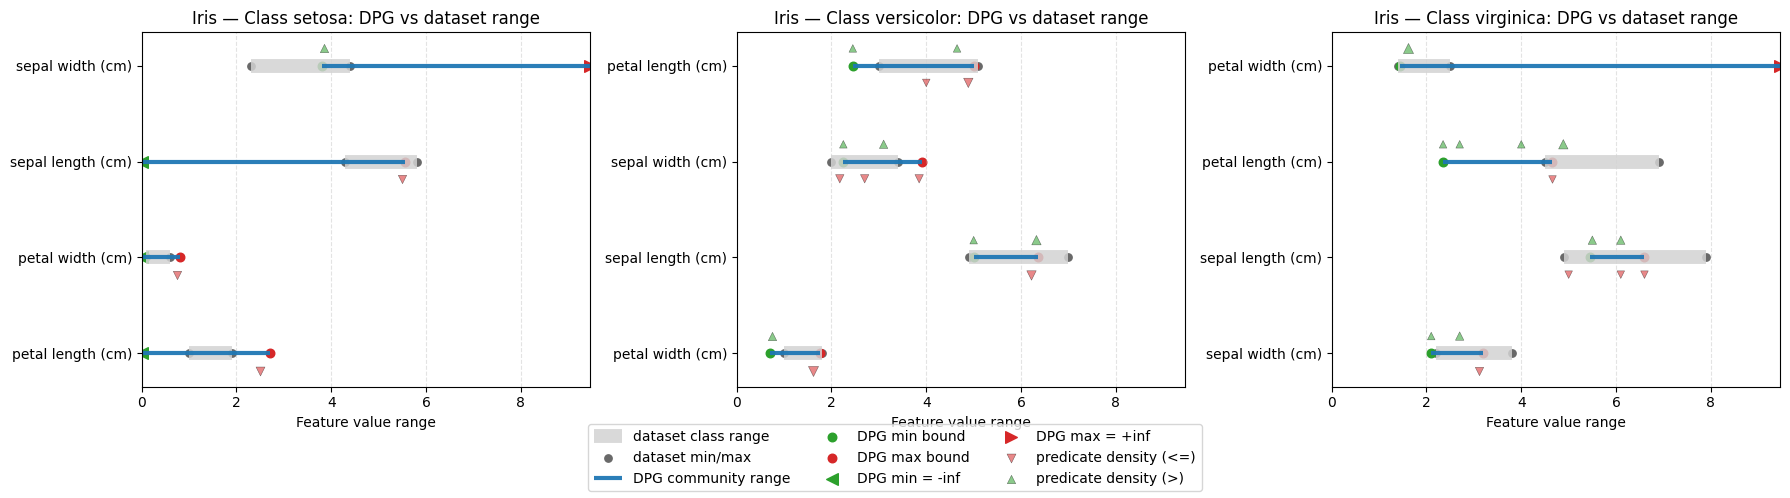

In [17]:
plot_dpg_class_bounds_vs_dataset_feature_ranges(
    class_bounds,
    X,
    y,
    dataset_name='Iris',
    top_features=4,
    class_lookup=class_lookup,
    predicate_positions=predicate_positions,
    save_path=IMG_DIR / 'dpg_vs_dataset_feature_ranges.png',
)


## 9. What to Say in the Story
Use this narrative to highlight **all DPG contributions** in a practitioner discussion:

- **LRC as a global logic driver (alternative lens to RF importance):** LRC identifies predicates that sit high in the decision flow and influence many downstream rules. While RF feature importance ranks features by split contribution, LRC shows *which concrete thresholds/rules* organize the model reasoning graph.
- **BC as bottleneck decision logic:** Betweenness centrality pinpoints predicates that connect major decision paths. In the PCA/BC cloud view, these predicates appear where dense transitional regions emerge, helping explain where the model switches between class regimes.
- **Communities for class-boundary structure:** Community groups reveal predicate themes per class and show how boundaries are formed as connected rule sets, not isolated splits. This makes class definitions interpretable at graph level.
- **Overlapped classes diagnosis:** Shared/neighboring communities and ambiguous regions expose where classes overlap (e.g., Versicolor vs Virginica), indicating where predictions are naturally harder and where boundary rules are less separable.
- **Class simplicity/complexity profiling:** Community-level predicate concentration and class complexity scores indicate which classes are explained by compact, stable rule sets (simpler) versus distributed, multi-threshold rule systems (more complex).
- **Class definition vs original dataset statistics:** Compare DPG predicates/boundaries with class-wise feature statistics (means, spreads, quantiles) from the raw data to validate whether discovered rules align with empirical class distributions and to detect model-specific biases.

In short: **DPG turns a forest from feature ranking into interpretable decision topology**: key drivers (LRC), transition bottlenecks (BC), class rule ecosystems (communities), overlap diagnostics, and class-level complexity grounded against dataset statistics.


## Next Episode
We will move to another scikit-learn benchmark dataset.
